In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from conditionalconformal import CondConf

/u/local/apps/python/3.9.6/gcc-4.8.5/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def run_experiment(N):
    
   # Data generation
    Z_space = [3, 5, 7]
    z = np.random.choice(Z_space, N)
    x_sd = 1  
    
    x = np.random.normal(loc=z/10, scale=x_sd, size=N)
    y = np.exp(x) * z + truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1

    # Creating data frames
    half_N = int(N/2)
    D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
    D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]}) 

    # Fit a eighth order polynomial
    poly = PolynomialFeatures(8)

    # Transform features
    X_poly = poly.fit_transform(D_train[['x', 'z']])

    # Train polynomial regression model
    reg = LinearRegression().fit(X_poly, D_train['y'])
    
    predictions = reg.predict(poly.transform(D_cali[['x', 'z']]))
    actual = np.exp(D_cali['x']) * D_cali['z'] + 1
    mse_cali = mean_squared_error(actual, predictions)
    
    # Calculate standard deviation of the errors
    errors = actual - predictions
    sd_errors = np.std(errors)
    
    
    return mse_cali, sd_errors

In [208]:
np.random.seed(1)
N_values = [100, 500, 1000, 5000, 10000, 50000]

num_iterations = 500
results_mse = []
results_sd = []
np.random.seed(1)
for N in N_values:
    mse_sum = 0
    sd_sum = 0
    for _ in range(num_iterations):
        mse, sd = run_experiment(N)
        mse_sum += mse
        sd_sum += sd
    average_mse = mse_sum / num_iterations
    average_sd = sd_sum / num_iterations
    results_mse.append(average_mse)
    results_sd.append(average_sd)



In [274]:
results_df = pd.DataFrame({'N': N_values, 'Average MSE': results_mse, 'Average SD': results_sd})
print(results_df)

       N   Average MSE  Average SD
0    100  1.764137e+06  333.604717
1    500  4.480603e+01    2.721339
2   1000  3.861856e+00    0.922444
3   5000  5.574788e-02    0.142998
4  10000  1.805907e-02    0.086558
5  50000  5.140143e-03    0.045262


In [3]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,1])

    # Initialize the indicator matrix
    matrix = np.zeros((len(scalar_values), 3))
    value_z = np.array([3,5,7])

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0,3):
            if  value == value_z[j]:
                matrix[i, j] = 1

    return matrix

In [5]:
np.random.seed(1)
# Data generation
Z_space = [3, 5, 7]
x_sd = 1
N = 1000
z = np.random.choice(Z_space, N)
x = np.random.normal(loc=z/10, scale=x_sd, size=N)
#x = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z) / 10, scale=x_sd, size=N)
y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1

# Creating data frames
half_N = int(N/2)
D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})

# fit a eighth order polynomial
poly = PolynomialFeatures(8)

# Conversion feature
X_poly = poly.fit_transform(D_train[['x', 'z']])

# Train polynomial regression models
reg = LinearRegression().fit(X_poly, D_train['y'])
    
# First, convert the new data (in this case the D_train features 'x' and 'z') into polynomial features
X_poly_new = poly.transform(D_train[['x', 'z']])

# Use trained models to make predictions
y_pred = reg.predict(X_poly_new)

In [6]:
# Set the seed
np.random.seed(1)
x_sd = 1
# Data generation
z_0 = 7
m = 1000
z_new = np.full(m, z_0)
x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
#x_new = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z_new) / 10, scale=x_sd, size=m)
y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})

# XGBoost
dtest_new = pd.DataFrame({'x': x_new, 'z': z_new})
predicted_values_poly_new = reg.predict(poly.transform(dtest_new))

In [7]:
alpha = 0.1
Xtest = np.array([new_data[['x', 'z']].to_numpy()[10,:]])

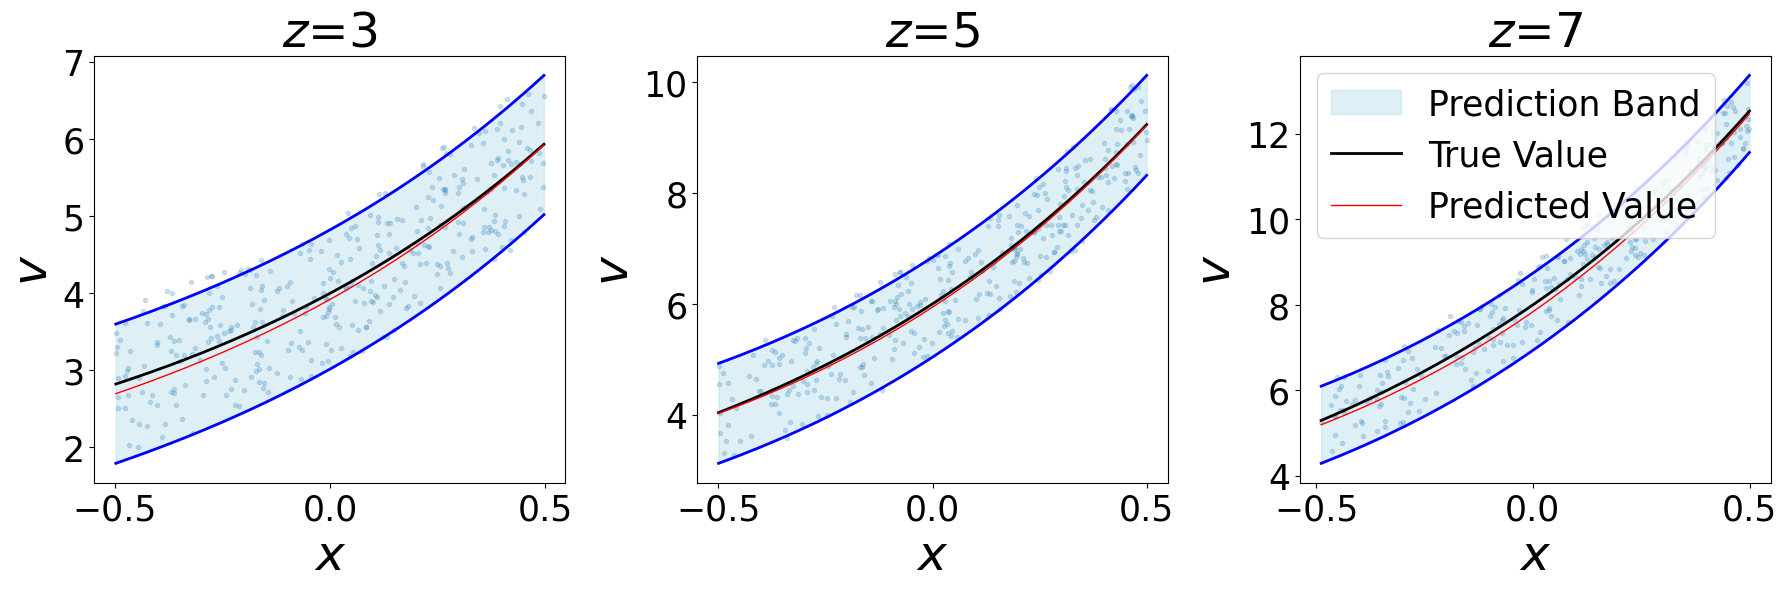

In [17]:

from matplotlib.patches import Patch
# Define the space for Z and the number of samples
Z_space = [3, 5, 7]
N = 1000

# Define scale for x (not provided in the question, assuming a value)
x_sd = 1

def generate_and_plot(z_0, ax, add_legend=False):
    # Set the seed for reproducibility
    np.random.seed(1)
    z = np.random.choice(Z_space, N)
    x = np.random.normal(loc=z/10, scale=x_sd, size=N)
    y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1
    # Creating data frames
    half_N = int(N/2)
    D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
    D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
    # fit a sixth order polynomial
    poly = PolynomialFeatures(6)
    X_poly = poly.fit_transform(D_train[['x', 'z']])
    reg = LinearRegression().fit(X_poly, D_train['y'])
    score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())

    m = 1000
    z_new = np.full(m, z_0)
    x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
    #x_new = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z_new) / 10, scale=x_sd, size=m)
    y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
    new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})

    dtest_new = pd.DataFrame({'x': x_new, 'z': z_new})
    predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)

    hat_t_L = predicted_values_poly_new - d 
    hat_t_U = predicted_values_poly_new + d 
    
    # Sort data for plotting and filter for x in [-0.5, 0.5]
    sort_order = np.argsort(new_data['x'])
    data = pd.DataFrame({
        'x': new_data['x'][sort_order],
        'y': new_data['y'][sort_order],
        'lower_ci': hat_t_L[sort_order],
        'upper_ci': hat_t_U[sort_order],
        'predicted': predicted_values_poly_new[sort_order],
        'true': np.exp(new_data['x'])[sort_order] * z_0 + 1
    })
    data_filtered = data[(data['x'] >= -0.5) & (data['x'] <= 0.5)]
    
    # Plotting using the filtered data
    ax.plot(data_filtered['x'], data_filtered['y'], '.', alpha=0.2)
    sns.lineplot(x='x', y='true', data=data_filtered, color='k', lw=2, ax=ax)
    sns.lineplot(x='x', y='predicted', data=data_filtered, color='red', lw=1, ax=ax)
    sns.lineplot(x='x', y='lower_ci', data=data_filtered, color='blue', lw=2, ax=ax)
    sns.lineplot(x='x', y='upper_ci', data=data_filtered, color='blue', lw=2, ax=ax)
    ax.fill_between(data_filtered['x'], data_filtered['lower_ci'], data_filtered['upper_ci'], color='lightblue', alpha=0.4)
    

    ax.set_ylabel('$v$',fontsize=35)
    ax.tick_params(axis='both', labelsize=25)
    ax.set_title(f'$z$={z_0}',fontsize=35)
    ax.set_xlabel("$x$",fontsize=35)
    ax.grid(False)
    
    if add_legend:
        # Create a legend for the fill_between area
        legend_patch = Patch(color='lightblue', alpha=0.4, label='Prediction Band')
        # Assuming you want to skip the first line (which might be the data points) and include the rest
        lines_for_legend = [ax.lines[i] for i in [1, 2]]  # Adjust the indices as needed
        # Add the legend to the plot
        ax.legend(handles=[legend_patch, *lines_for_legend], labels=['Prediction Band', 'True Value', 'Predicted Value'],fontsize=25)



    
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, z_0 in enumerate(Z_space):
    generate_and_plot(z_0, axs[i], add_legend=(i == len(Z_space) - 1))


plt.tight_layout()
plt.show()

In [30]:

def conformal_predict_z_0(alpha=0.1, m=2500, z_0=3):
    IR = []
    for j in range(1000):
        Z_space = [3, 5, 7]
        N = 1000
        z = np.random.choice(Z_space, N)
        x = np.random.normal(loc=z/10, scale=x_sd, size=N)
        #x = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z) / 10, scale=x_sd, size=N)
        y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1
        # Creating data frames
        half_N = int(N/2)
        D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
        D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
        # fit a sixth order polynomial
        poly = PolynomialFeatures(6)
        X_poly = poly.fit_transform(D_train[['x', 'z']])
        reg = LinearRegression().fit(X_poly, D_train['y'])
        score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())
        
        z_new = np.full(m, z_0)
        #x_new = stats.truncnorm.rvs(a=-z_new, b=z_new, loc=np.array(z_new) / 10, scale=x_sd, size=m)
        x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
        y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
        # Create new data
        new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})
        dtest_new = pd.DataFrame({'x': x_new, 'z': z_new})
        predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
        Xtest = np.array([new_data[['x', 'z']].to_numpy()[11,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        # Calculate intervals
        hat_t_L = predicted_values_poly_new - d
        hat_t_U = predicted_values_poly_new + d
        IR.append(np.mean((hat_t_L <= new_data['y']) & (new_data['y'] <= hat_t_U) ))
    return IR, d

In [31]:
np.random.seed(1)
IR_7, d_7 = conformal_predict_z_0(alpha=0.1, m=1000, z_0=7)
IR_3, d_3 = conformal_predict_z_0(alpha=0.1, m=1000, z_0=3)
IR_5, d_5 = conformal_predict_z_0(alpha=0.1, m=1000, z_0=5)


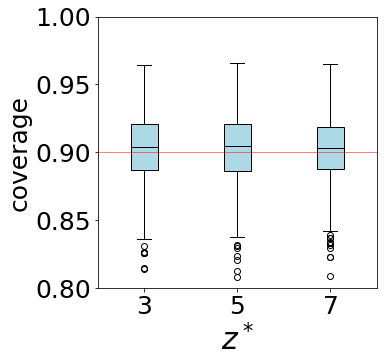

In [32]:
fig = plt.figure(figsize=(5, 5))

IR = [IR_3, IR_5, IR_7]  

plt.boxplot(IR, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='lightblue'))

plt.axhline(y=1-alpha, color='red', linestyle='-', label='', linewidth=0.5,zorder=3)
plt.ylim(0.8, 1)
plt.xlabel('$z^*$', fontsize=30)
plt.ylabel('coverage', fontsize=25)
plt.locator_params(axis='y', nbins=5)  
plt.yticks( fontsize=25)
plt.xticks([1, 2, 3], [3, 5, 7], fontsize=25)  
plt.show()


In [13]:
def conformal_predict(m=1000, z_0=3, N = 1000):
    # Data generation
    Z_space = [3, 5, 7]
    z = np.random.choice(Z_space, N)
    x = np.random.normal(loc=z/10, scale=x_sd, size=N)
    #x = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z) / 10, scale=x_sd, size=N)
    y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1
    # Creating data frames
    half_N = int(N/2)
    D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
    D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
    # fit a eighth order polynomial
    poly = PolynomialFeatures(8)
    X_poly = poly.fit_transform(D_train[['x', 'z']])
    reg = LinearRegression().fit(X_poly, D_train['y'])    
    score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())
    
    
    z_new = np.full(m, z_0)
    x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
    y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
    new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})
    dtest_new = pd.DataFrame(new_data[['x', 'z']])
    predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
    Xtest = np.array([new_data[['x', 'z']].to_numpy()[11,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        
    reserve_price = predicted_values_poly_new - d
    virtual_value = new_data['y'] * (new_data['y'] > reserve_price)
    
    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]

    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]
    

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(new_data['y'])

    return payment, payment/max_welfare, payment - np.sort(new_data['y'])[::-1][1], np.sort(new_data['y'])[::-1][1], max_welfare

In [28]:
np.random.seed(1)
m_0 = 50
IR_3_compare = []
ratio_3 = []
Pay_3 = []

for i in range(1000):
    result = conformal_predict(m=m_0, z_0=3)
    IR_3_compare.append(result[2])
    ratio_3.append(result[1])
    Pay_3.append(result[0])
    
IR_5_compare = []
ratio_5 = []
Pay_5 = []
for i in range(1000):
    result = conformal_predict(m=m_0, z_0=5)
    IR_5_compare.append(result[2])
    ratio_5.append(result[1])
    Pay_5.append(result[0])

IR_7_compare = []
ratio_7 = []
Pay_7 = []
for i in range(1000):
    result = conformal_predict(m=m_0, z_0=7)
    IR_7_compare.append(result[2])
    ratio_7.append(result[1])
    Pay_7.append(result[0])



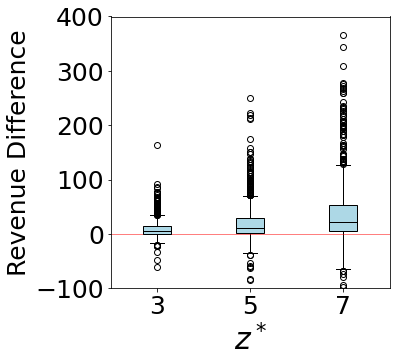

In [29]:
fig = plt.figure(figsize=(5, 5))

data = [IR_3_compare, IR_5_compare, IR_7_compare]

plt.boxplot(data, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='lightblue'))

plt.axhline(y=0, color='red', linestyle='-', label='', linewidth=0.5)
plt.ylim(-100, 400)
plt.xlabel('$z^*$', fontsize=30)
plt.ylabel('Revenue Difference', fontsize=25)
plt.locator_params(axis='y', nbins=5)  
plt.yticks( fontsize=25)
plt.xticks([1, 2, 3], [3, 5, 7], fontsize=25)  
plt.show()


In [26]:
np.random.seed(1)
N_values = [100, 500, 1000, 2500, 5000]
z_values = [3, 5, 7]
num_runs = 1000

# Initialize results dictionary for each z_0 value
results = {z: {"payment": [], "sb_value": [], "max_welfare": []} for z in z_values}

# Simulation for each z value
for z_0 in z_values:
    np.random.seed(1)
    for N in N_values:
        payments, sb_values, max_welfares = [], [], []
        for _ in range(num_runs):
            payment, _, _, sb_value, max_welfare = conformal_predict(50, z_0, N)
            payments.append(payment)
            sb_values.append(sb_value)
            max_welfares.append(max_welfare)
        results[z_0]["payment"].append(np.mean(payments))
        results[z_0]["sb_value"].append(np.mean(sb_values))
        results[z_0]["max_welfare"].append(np.mean(max_welfares))



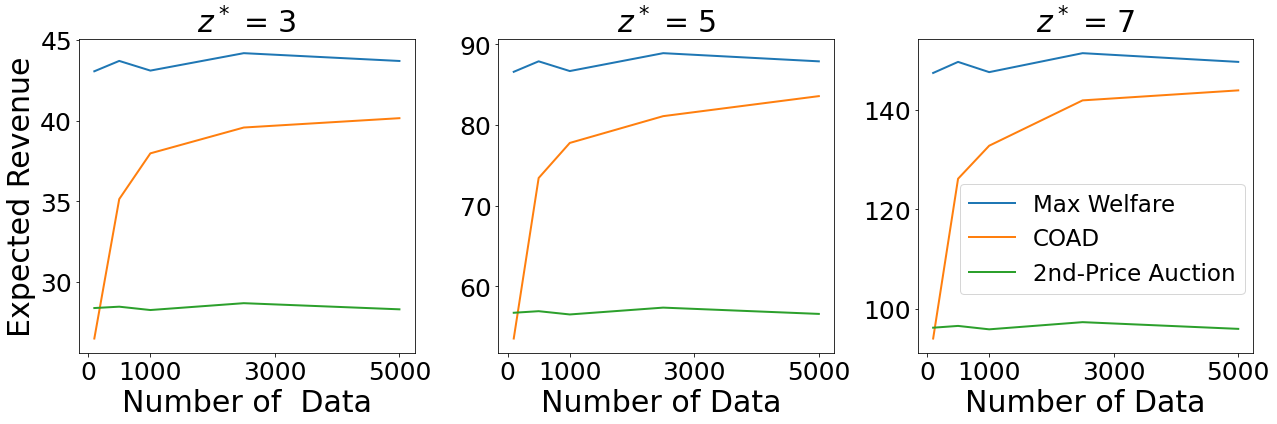

In [27]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

i = 0; z_0 = 3
axs[i].plot(N_values, results[z_0]["max_welfare"], label="Max Welfare", linewidth=2)
axs[i].plot(N_values, results[z_0]["payment"], label="Payment", linewidth=2)
axs[i].plot(N_values, results[z_0]["sb_value"], label="2nd highest Price", linewidth=2)
axs[i].set_xlabel("Number of  Data", fontsize =30)
axs[i].set_ylabel("Expected Revenue",fontsize=30)
axs[i].set_title(f"$z^*$ = {z_0}", fontsize =30)
axs[i].tick_params(axis='y', labelsize=25)
axs[i].tick_params(axis='x', labelsize=25)
axs[i].locator_params(axis='y', nbins=6)
axs[i].set_xticks([0,1000,3000,5000])

i = 1; z_0 = 5
axs[i].plot(N_values, results[z_0]["max_welfare"], label="Max Welfare", linewidth=2)
axs[i].plot(N_values, results[z_0]["payment"], label="Payment", linewidth=2)
axs[i].plot(N_values, results[z_0]["sb_value"], label="2nd highest Price", linewidth=2)
axs[i].set_xlabel("Number of Data ", fontsize =30)
axs[i].set_title(f"$z^*$ = {z_0}", fontsize =30)
axs[i].tick_params(axis='y', labelsize=25)
axs[i].tick_params(axis='x', labelsize=25)
axs[i].locator_params(axis='y', nbins=6)
axs[i].set_xticks([0,1000,3000,5000])


i = 2; z_0 = 7
axs[i].plot(N_values, results[z_0]["max_welfare"], label="Max Welfare", linewidth=2)
axs[i].plot(N_values, results[z_0]["payment"], label="COAD", linewidth=2)
axs[i].plot(N_values, results[z_0]["sb_value"], label="2nd-Price Auction", linewidth=2)
axs[i].set_xlabel("Number of Data", fontsize =30)
axs[i].set_title(f"$z^*$ = {z_0}", fontsize =30)
axs[i].set_xticks([0,1000,3000,5000])

axs[i].legend(fontsize=23,bbox_to_anchor=(0.09, 0.15))
axs[i].tick_params(axis='y', labelsize=25)
axs[i].tick_params(axis='x', labelsize=25)
axs[i].locator_params(axis='y', nbins=6)



plt.tight_layout()
plt.show()

In [24]:
# Setting the initial seed
np.random.seed(1)


m_values = list(range(50, 401, 50))
N = 1000
num_runs = 1000
z_0_values = [3, 5, 7]  # Different z values for each plot
# Initialize results dictionary for each z value
results_m = {z: {"payment": [], "y_value": [], "max_welfare": []} for z in z_values}

for i, z_0 in enumerate(z_0_values):
    np.random.seed(0)
    for m in m_values:
        payments, y_values, max_welfares = [], [], []
        for _ in range(num_runs):
            payment, _, _, y_value, max_welfare = conformal_predict(m, z_0, N)
            payments.append(payment)
            y_values.append(y_value)
            max_welfares.append(max_welfare)

        results_m[z_0]["payment"].append(np.mean(payments))
        results_m[z_0]["y_value"].append(np.mean(y_values))
        results_m[z_0]["max_welfare"].append(np.mean(max_welfares))

 

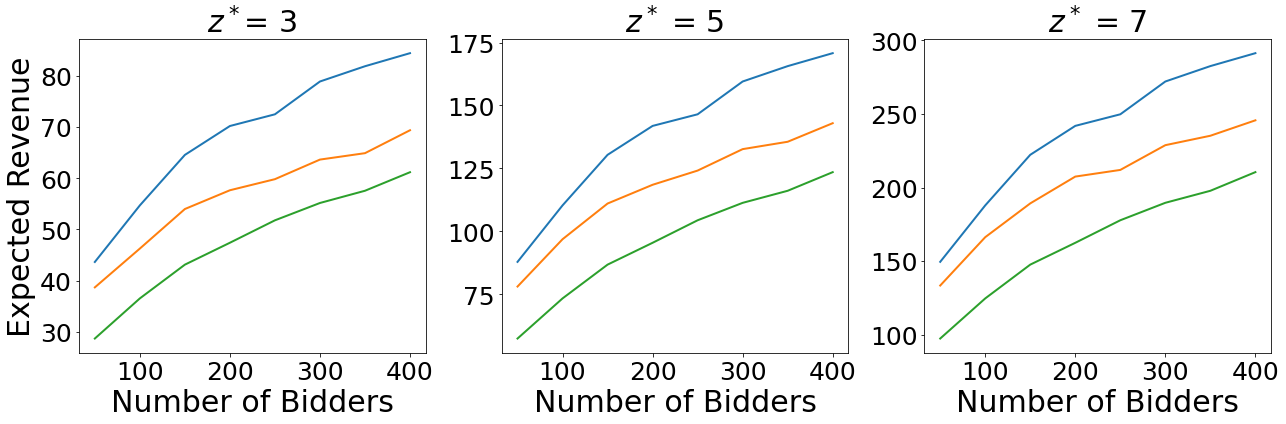

In [25]:

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

i = 0; z_0 = 3   
axs[i].plot(m_values, results_m[z_0]["max_welfare"], label="Max Welfare", linewidth=2)
axs[i].plot(m_values, results_m[z_0]["payment"], label="Payment", linewidth=2)
axs[i].plot(m_values, results_m[z_0]["y_value"], label="2nd Best Price", linewidth=2)
axs[i].set_xlabel("Number of Bidders", fontsize=30)
axs[i].set_ylabel("Expected Revenue", fontsize=30)
axs[i].tick_params(axis='both', which='major', labelsize=25)
axs[i].locator_params(axis='y', nbins=7)
axs[i].set_title(f"$z^*$= {z_0}", fontsize=30)

i = 1; z_0 = 5 
axs[i].plot(m_values, results_m[z_0]["max_welfare"], label="Max Welfare", linewidth=2)
axs[i].plot(m_values, results_m[z_0]["payment"], label="Payment", linewidth=2)
axs[i].plot(m_values, results_m[z_0]["y_value"], label="2nd Best Price", linewidth=2)
axs[i].set_xlabel("Number of Bidders", fontsize=30)
axs[i].tick_params(axis='both', which='major', labelsize=25)
axs[i].set_title(f"$z^*$ = {z_0}", fontsize=30)

i = 2; z_0 = 7
axs[i].plot(m_values, results_m[z_0]["max_welfare"], label="Max Welfare", linewidth=2)
axs[i].plot(m_values, results_m[z_0]["payment"], label="COAD", linewidth=2)
axs[i].plot(m_values, results_m[z_0]["y_value"], label="2nd-Price Auction", linewidth=2)
axs[i].set_xlabel("Number of Bidders", fontsize=30)
axs[i].tick_params(axis='both', which='major', labelsize=25)
axs[i].set_title(f"$z^*$ = {z_0}", fontsize=30)
plt.tight_layout()

# Showing the plot
plt.show()